In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
from itertools import product
from sklearn.model_selection import KFold

In [2]:
print(os.listdir("../input/competitive-data-science-predict-future-sales"))

['items.csv', 'sales_train.csv', 'item_categories.csv', 'test.csv', 'shops.csv', 'sample_submission.csv']


In [3]:
#read data
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
cats = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
transactions = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

In [4]:
un = transactions.nunique(dropna = False)
un.sort_values()[:10]

date_block_num       34
shop_id              60
item_cnt_day        198
date               1034
item_price        19993
item_id           21807
dtype: int64

In [5]:
items.head()


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
transactions['day'] = pd.DatetimeIndex(transactions['date'], dayfirst = True).day
transactions['month'] = pd.DatetimeIndex(transactions['date'], dayfirst = True).month
transactions['year'] = pd.DatetimeIndex(transactions['date'], dayfirst = True).year
transactions = transactions.merge(items.drop(['item_name'], axis = 1), on = 'item_id')
transactions.head

<bound method NDFrame.head of                date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154       999.0   
1        23.01.2013               0       24    22154       999.0   
2        20.01.2013               0       27    22154       999.0   
3        02.01.2013               0       25    22154       999.0   
4        03.01.2013               0       25    22154       999.0   
...             ...             ...      ...      ...         ...   
2935844  17.10.2015              33       25     8428       249.0   
2935845  01.10.2015              33       25     7903     12198.0   
2935846  29.10.2015              33       25     7610      2890.0   
2935847  22.10.2015              33       25     7635      2100.0   
2935848  01.10.2015              33       25     7640      4040.0   

         item_cnt_day  day  month  year  item_category_id  
0                 1.0    2      1  2013                37  
1                 1.0

In [7]:
transactions.isnull().sum(axis=0).head(15)

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
day                 0
month               0
year                0
item_category_id    0
dtype: int64

In [8]:
#Creating a grid to have our data in monthly format
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions[transactions['date_block_num'] == block_num]['shop_id'].unique()
    cur_items = transactions[transactions['date_block_num'] == block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
#to dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [9]:
#Create mean encodings
mean_transactions = transactions.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()

mean_transactions = pd.merge(grid,mean_transactions,on=['date_block_num', 'shop_id', 'item_id'],how='left').fillna(0)

mean_transactions = pd.merge(mean_transactions, items, on='item_id',how='left')

mean_transactions.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


In [10]:
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        
        mean_df = transactions.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        mean_transactions = pd.merge(mean_transactions, mean_df, on=['date_block_num',type_id], how='left')

In [11]:
#Creating Lag Variables
lag_variables  = list(mean_transactions.columns[7:])+['item_cnt_day']
lags = [1, 2, 3]
from tqdm import notebook

for lag in notebook.tqdm(lags):

    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    mean_transactions = pd.merge(mean_transactions, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')


In [12]:
mean_transactions.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,...,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
mean_transactions = mean_transactions[mean_transactions['date_block_num']>12]

for feat in mean_transactions.columns:
    if 'item_cnt' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(0)
    elif 'item_price' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(mean_transactions[feat].median())

In [14]:
cols_to_drop = lag_variables[:-1] + ['item_price', 'item_name'] # dropping all target variables but not "item_cnt_day" cause is target
train= mean_transactions.drop(cols_to_drop,axis=1)
train.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,...,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3
2972878,6,22154,30,1.0,37,340.011765,0.0,0.000000,1005.883353,0.0,...,318.250000,0.0,0.000000,988.499731,0.0,0.000000,408.500466,0.0,0.000000,0.0
2972879,6,2574,30,0.0,55,449.000000,24.0,0.923077,1070.927764,1539.0,...,445.600000,35.0,1.000000,1097.504666,1998.0,1.397203,308.066712,7162.0,1.031988,2.0
2972880,6,2607,30,0.0,55,299.000000,21.0,1.050000,1070.927764,1539.0,...,299.000000,21.0,1.000000,1097.504666,1998.0,1.397203,308.066712,7162.0,1.031988,1.0
2972881,6,2614,30,0.0,55,299.000000,6.0,1.000000,1070.927764,1539.0,...,299.000000,7.0,1.000000,1097.504666,1998.0,1.397203,308.066712,7162.0,1.031988,1.0
2972882,6,2808,30,0.0,30,1489.976154,54.0,1.038462,1070.927764,1539.0,...,1311.807262,89.0,1.059524,1097.504666,1998.0,1.397203,611.333626,14751.0,2.407933,2.0


In [15]:
#Preparing our test set for predicitons and making it similar to our training set.
#lag features
test['date_block_num'] = 34
test = pd.merge(test, items, on='item_id', how='left')

for lag in notebook.tqdm(lags):

    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    test = pd.merge(test, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [16]:
test.head()

,ID,shop_id,item_id,date_block_num,item_name,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,...,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3
0,0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,1499.000000,25.0,1.000000,1030.721934,...,894.589833,119.0,1.190000,921.70297,1294.0,1.080134,1140.894671,4667.0,1.126207,3.0
1,1,5,5320,34,ONE DIRECTION Made In The A.M.,55,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,1199.000000,42.0,1.024390,1030.721934,...,712.152323,150.0,1.181102,921.70297,1294.0,1.080134,1140.894671,4667.0,1.126207,1.0
3,3,5,5232,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,1190.433333,28.0,0.933333,1030.721934,...,642.466296,65.0,1.203704,921.70297,1294.0,1.080134,1164.672498,3650.0,1.093142,1.0
4,4,5,5268,34,"Need for Speed [PS4, русская версия]",20,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#drop unnecessary columns
test2 = test.drop(['ID', 'item_name'], axis=1).columns
train2 = train.drop('item_cnt_day',axis=1).columns
test2 == train2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [18]:
test = test.drop(['ID', 'item_name'], axis=1)


In [19]:
#fill na's
for feat in test.columns:
    if 'item_cnt' in feat:
        test[feat]=test[feat].fillna(0)
    elif 'item_price' in feat:
        test[feat]=test[feat].fillna(test[feat].median())


In [20]:
test[['shop_id','item_id']+['item_cnt_day_lag_'+str(x) for x in [1, 2, 3]]].head()

,shop_id,item_id,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3
0,5,5037,0.0,1.0,3.0
1,5,5320,0.0,0.0,0.0
2,5,5233,1.0,3.0,1.0
3,5,5232,0.0,0.0,1.0
4,5,5268,0.0,0.0,0.0


In [21]:
#confirming results
print(train[train['shop_id'] == 5][train['item_id'] == 5037][train['date_block_num'] == 33]['item_cnt_day'])
print(train[train['shop_id'] == 5][train['item_id'] == 5037][train['date_block_num'] == 32]['item_cnt_day'])
print(train[train['shop_id'] == 5][train['item_id'] == 5037][train['date_block_num'] == 31]['item_cnt_day'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


3756718    0.0
Name: item_cnt_day, dtype: float64
3485182    1.0
Name: item_cnt_day, dtype: float64
3281361    3.0
Name: item_cnt_day, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Time to Train our Model using Ensemble techniques


In [22]:
#split into train & validation sets.
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(train.iloc[:, train.columns != 'item_cnt_day'].values, train.iloc[:, train.columns == 'item_cnt_day'].values, test_size = 0.5)


In [23]:
import xgboost as xgb
# xgb 1
dtrain = xgb.DMatrix(X_train, Y_train)
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.45,
         'eta':0.3, 
         'seed':1,
         'eval_metric':'rmse'}
bst1 = xgb.train(param, dtrain)

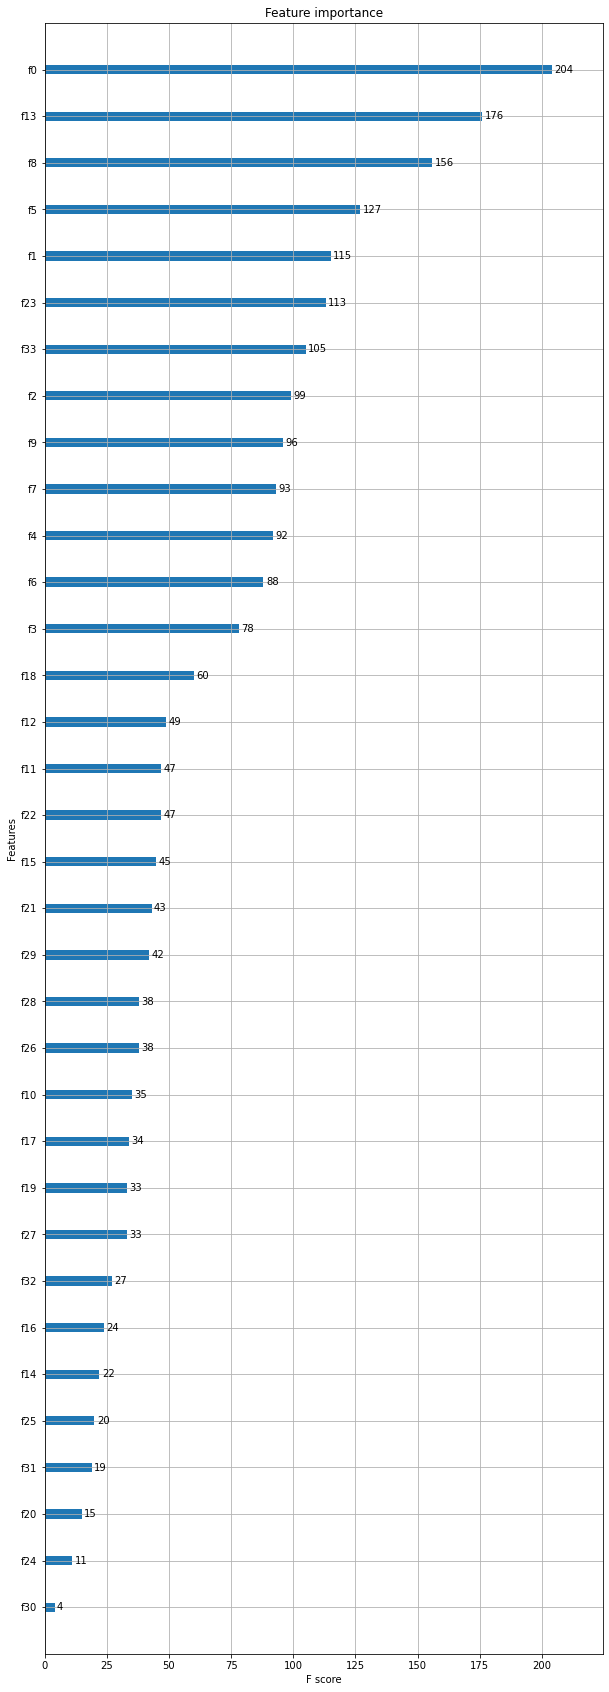

In [24]:
x=xgb.plot_importance(bst1)
x.figure.set_size_inches(10, 30) 

In [25]:
# xgb 2
param = {'max_depth':15, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'seed':1,
         'eval_metric':'rmse'}
bst2 = xgb.train(param, dtrain)

In [26]:
# xgb 3
param = {'max_depth':5, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'seed':1,
         'eval_metric':'rmse'}
bst3 = xgb.train(param, dtrain)

In [27]:
#lr1
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr1.fit(X_train, Y_train)

LinearRegression()

In [28]:
#predict on validation set
dvalid = xgb.DMatrix(X_valid)
valid_preds1 = bst1.predict(dvalid)
valid_preds2 = bst2.predict(dvalid)
valid_preds3 = bst3.predict(dvalid)
valid_preds4 = lr1.predict(X_valid)

In [29]:
#predict on test set
dtest = xgb.DMatrix(test.values)
test_preds1 = bst1.predict(dtest)
test_preds2 = bst2.predict(dtest)
test_preds3 = bst3.predict(dtest)
test_preds4 = lr1.predict(test)

In [30]:
stacked_predictions = np.column_stack([valid_preds1,valid_preds2,valid_preds3,valid_preds4])
stacked_test_predictions = np.column_stack([test_preds1,test_preds2,test_preds3,test_preds4])

In [31]:
#Making our Final predictions of ensemble.
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, Y_valid)
meta_predictions = meta_model.predict(stacked_test_predictions)
preds = meta_predictions.clip(0, 20).ravel()
print(meta_predictions.shape)

(214200, 1)


In [32]:
#to dataframe
df = pd.DataFrame({'ID':test.index,'item_cnt_month': preds })
df.head()

,ID,item_cnt_month
0,0,0.618797
1,1,0.193692
2,2,0.836099
3,3,0.415960
4,4,1.430085


In [33]:
df.to_csv('submission.csv',index=False)

The mean encodings and lag feature code was reused from the [notebook](https://www.kaggle.com/alessandrosolbiati/using-xgboost-for-time-series-prediction-top-20).
All thanks to the guy.